<a href="https://colab.research.google.com/github/SJG0510/Private-Project-Practice/blob/main/Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# 데이터 로드 및 전처리
import pandas as pd
import urllib.parse
import re

# GitHub raw 파일 기본 경로
base_url = "https://raw.githubusercontent.com/SJG0510/Private-Project-Practice/data/"
file_name = '시도_현재흡연.csv'
file_name2 = '시도_고위험음주csv'
url = base_url + urllib.parse.quote(file_name)

# 데이터 로드 (utf-8-sig → cp949 순으로 시도)
try:
    df_raw = pd.read_csv(url, encoding='utf-8-sig')
except UnicodeDecodeError:
    df_raw = pd.read_csv(url, encoding='cp949')

# '95% CI' 컬럼 제거
if '95% CI' in df_raw.columns:
    df_raw.drop(columns=['95% CI'], inplace=True)

# 연도 컬럼(2008~2024)만 골라내기
year_cols = [c for c in df_raw.columns if re.match(r"^\d{4}$", c)]

# 숫자+소수점만 뽑아 float로 변환하는 헬퍼 함수
def to_numeric(val):
    if pd.isna(val):
        return None
    nums = re.findall(r"[-+]?\d*\.\d+|\d+", str(val))
    return float(nums[0]) if nums else None

# ‘전체’, ‘남/여’, ‘연령대’별로 따로 떼어놓기
전체_df = df_raw[df_raw.iloc[:,1] == '전체'].copy()
성별_df = df_raw[df_raw.iloc[:,1].isin(['남','여'])].copy()
연령_df = df_raw[df_raw.iloc[:,1].isin(['19-29','30-39','40-49','50-59','60-69','70이상'])].copy()

# 연도별 컬럼을 to_numeric으로 모두 변환하고, 컬럼명 통일 및 인덱스 리셋
for D in (전체_df, 성별_df, 연령_df):
    # 숫자 변환
    for y in year_cols:
        D[y] = D[y].apply(to_numeric)
    # 첫 두 컬럼을 '시도', '구분'으로 이름 바꾸기
    D.rename(columns={ D.columns[0]: '시도', D.columns[1]: '구분' }, inplace=True)
    D.reset_index(drop=True, inplace=True)

print("✅ 셀1 완료: 전체_df, 성별_df, 연령_df 준비됨")
print("연도 컬럼:", year_cols)

✅ 셀1 완료: 전체_df, 성별_df, 연령_df 준비됨
연도 컬럼: ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [23]:
# 모델 학습·예측 함수
import numpy as np
from sklearn.linear_model import LinearRegression

def train_linear_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

def predict_future(model, last_year, predict_years=2):
    future_years = np.arange(last_year + 1, last_year + 1 + predict_years).reshape(-1, 1)
    preds = model.predict(future_years)
    return future_years.flatten(), preds

def fit_region_category(region, category):
    """
    region: 시도명 (예: '서울특별시')
    category: '전체', '남', '여', '19-29', ..., '70이상'
    """
    if category == '전체':
        df = 전체_df
    elif category in ['남', '여']:
        df = 성별_df
    else:
        df = 연령_df

    sub = df[(df['시도'] == region) & (df['구분'] == category)]
    if sub.empty:
        return None, None, None

    X = np.array([int(y) for y in year_cols]).reshape(-1, 1)
    y = sub.loc[:, year_cols].values.flatten()

    model = train_linear_regression(X, y)
    return model, X.flatten(), y

print(" 완료: 모델 학습·예측 함수 정의됨")


 완료: 모델 학습·예측 함수 정의됨


In [27]:
# 셀3: 특정 region-category 실제값 출력 함수
def show_region_category_data(region, category):
    """
    region: 시도명 (예: '서울')
    category: '전체', '남', '여', '19-29', ..., '70이상'
    """
    # 카테고리별로 사용할 DataFrame 선택
    if category == '전체':
        df = 전체_df
    elif category in ['남', '여']:
        df = 성별_df
    else:
        df = 연령_df

    # 필터링: 시도 == region AND 구분 == category
    sub = df[(df['시도'] == region) & (df['구분'] == category)]
    if sub.empty:
        print(f"No data for {region} – {category}.")
        return

    # 출력
    print(f"\n▶ {region} – {category} Actual Smoking Rates (2008–2024):")
    display_cols = ['시도', '구분'] + year_cols
    print(sub[display_cols].to_string(index=False))

# 예시 호출
show_region_category_data('서울', '여')


▶ 서울 – 여 Actual Smoking Rates (2008–2024):
시도 구분  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024
서울  여   3.7   4.0   3.6   3.5   3.7   3.7   3.4   3.4   3.4   3.3   3.6   3.5   3.0   2.7   3.5   4.0   3.9


Available regions: 서울, 부산, 대구, 인천, 광주, 대전, 울산, 세종, 경기, 강원, 충북, 충남, 전북, 전남, 경북, 경남, 제주
Available categories: 전체, 남, 여, 19-29, 30-39, 40-49, 50-59, 60-69, 70이상
Enter region: 제주
Enter category (comma separated): 전체

▶ 제주 – 전체 Actual Smoking Rates (2008–2024):
시도 구분  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024
제주 전체  26.5  27.5  26.4  26.7  24.9  25.0  23.9  20.8  25.3  22.0  21.3  20.0  18.1  19.1  20.8  18.6  19.2

[제주 - 전체] Years:       [2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023 2024]
[제주 - 전체] Actual:      [26.5 27.5 26.4 26.7 24.9 25.  23.9 20.8 25.3 22.  21.3 20.  18.1 19.1
 20.8 18.6 19.2]
[제주 - 전체] Predicted Y: [2025 2026]
[제주 - 전체] Predicted:   [17.45073529 16.86617647]



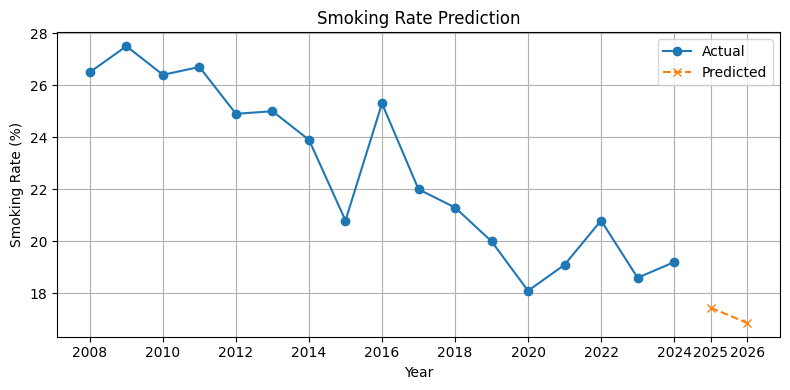

In [34]:
# 셀4: 인터랙티브 예측 및 시각화 (영어 레이블, xticks 커스터마이징)
import matplotlib.pyplot as plt

# 1) 사용 가능한 지역 및 카테고리 목록 불러오기
regions    = 전체_df['시도'].unique()
categories = ['전체','남','여','19-29','30-39','40-49','50-59','60-69','70이상']

print("Available regions:", ", ".join(regions))
print("Available categories:", ", ".join(categories))

# 2) 사용자로부터 입력 받기
region    = input("Enter region: ").strip()
cat_input = input("Enter category (comma separated): ")
chosen    = [c.strip() for c in cat_input.split(',')]

for cat in chosen:
    # 실제 데이터 출력
    show_region_category_data(region, cat)

    # 모델 학습 및 예측
    model, years, rates = fit_region_category(region, cat)
    if model is None:
        print(f"[{region} - {cat}] No data available.\n")
        continue

    # 마지막 연도와 예측 결과 계산
    last_year             = years[-1]
    pred_years, pred_rates = predict_future(model, last_year, predict_years=2)

    # 결과 콘솔 출력
    print(f"\n[{region} - {cat}] Years:       {years}")
    print(f"[{region} - {cat}] Actual:      {rates}")
    print(f"[{region} - {cat}] Predicted Y: {pred_years}")
    print(f"[{region} - {cat}] Predicted:   {pred_rates}\n")

    # 과거 데이터는 2년 단위로, 예측은 연도 모두 표시
    plt.figure(figsize=(8,4))
    plt.plot(years,      rates,      'o-', label='Actual')
    plt.plot(pred_years, pred_rates, 'x--', label='Predicted')

    # 2008~2024까지 2년마다, + 2025, 2026
    hist_ticks = list(range(2008, 2025, 2))
    ticks      = hist_ticks + pred_years.tolist()
    labels     = [str(y) for y in hist_ticks] + [str(int(y)) for y in pred_years]

    plt.xticks(ticks, labels)
    plt.title(f"Smoking Rate Prediction")
    plt.xlabel("Year")
    plt.ylabel("Smoking Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()